We explored the method of empirical Bayes estimation for all basketball players, even for the ones with 0 goals out of 1 attempt. But we can't only reply on a single value for each player. We would want to know how much uncertainty is present in our estimate. 

In many cases, statisticians would use a binomial proportion confidence interval, but this doesn't bring in information from our whole dataset. We will compute a credible interval which is similar to the confidence intervals but improved one.

In [1]:
import os
import math
import pandas as pd
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_dir = '/mnt/data-ubuntu/Projects/statistics_python3'
df = pd.read_csv(project_dir + '/data/nba-players-stats/seasons_stats_pg.csv')

In [3]:
df.loc[:,'2P%'][(df.loc[:,'2P%']<1) & (df.loc[:,'2P%']>0)]

0       0.322581
1       0.331787
2       0.357384
3       0.329600
4       0.311938
          ...   
4643    0.486339
4644    0.485294
4645    0.489362
4646    0.453488
4647    0.428571
Name: 2P%, Length: 4546, dtype: float64

In [4]:
data = df.loc[:,'2P%'][(df.loc[:,'2P%']<1) & (df.loc[:,'2P%']>0)]
beta_fit = beta.fit(data = data, floc=0, fscale=1)
a = round(beta_fit[0], 2)
b = round(beta_fit[1], 2)
print(f'a: {a},b: {b}')
df.head()

a: 20.52,b: 26.41


,Unnamed: 0,Year,Player,Pos,2P,2PA,2P%,2P%_estimate
0,11,1950.0,Nelson Bobb,PG,80.0,248.0,0.322581,0.340827
1,32,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.342142
2,49,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361398
3,108,1950.0,Red Holzman*,PG,206.0,625.0,0.329600,0.337118
4,114,1950.0,Ralph Johnson,PG,243.0,779.0,0.311938,0.319059


## Calculate the credible interval
We start with a prior distribution, then update to a
posterior distribution(Beta Distribution). 
$B(a + hits, b + misses)$. The math can be found [here](https://en.wikipedia.org/wiki/Conjugate_prior#Example)

In [5]:
# Calculate the credible interval based on each player's a and b
# We set a credible interval at 95%.
df['a_i'] = df.loc[: ,'2P'] + a
df['b_i'] = df.loc[: ,'2PA']-df.loc[: ,'2P'] + b
df['low'] = df.apply(lambda x: beta.ppf(0.025, x.a_i, x.b_i, loc=0, scale=1), axis = 1)
df['high'] = df.apply(lambda x: beta.ppf(0.975, x.a_i, x.b_i, loc=0, scale=1), axis = 1)
df.head()

,Unnamed: 0,Year,Player,Pos,2P,2PA,2P%,2P%_estimate,a_i,b_i,low,high
0,11,1950.0,Nelson Bobb,PG,80.0,248.0,0.322581,0.340827,100.52,194.41,0.287892,0.395806
1,32,1950.0,Al Cervi*,PG,143.0,431.0,0.331787,0.342142,163.52,314.41,0.300301,0.385235
2,49,1950.0,Bob Davies*,PG,317.0,887.0,0.357384,0.361398,337.52,596.41,0.330893,0.392465
3,108,1950.0,Red Holzman*,PG,206.0,625.0,0.329600,0.337118,226.52,445.41,0.301874,0.373281
4,114,1950.0,Ralph Johnson,PG,243.0,779.0,0.311938,0.319059,263.52,562.41,0.287715,0.351232


In [6]:
# Lets select 5 players and compare their performance
df_5 = df.iloc[[1,200,800,2000,4000], :]
# Calculate interviels.
error = df_5 \
    .loc[:, ['2P%_estimate', 'low','high']]
error['low'] = error.loc[:, 'low'] - error.loc[:, '2P%_estimate']
error['high'] = error.loc[:, 'high'] - error.loc[:, '2P%_estimate']
error = error.loc[:, ['low','high']]

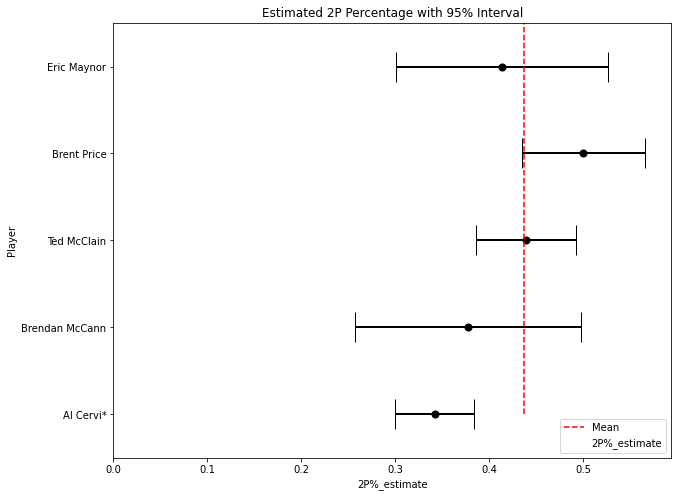

In [12]:
# Plot the credible intervals
fig,ax = plt.subplots(figsize=(10, 8))

df_5 \
    .set_index('Player') \
    .loc[:, '2P%_estimate'] \
    .plot(kind = 'barh',
          alpha = 0,
          ax = ax,
          xerr = error.values.T,
          error_kw = {'capsize':15, 'elinewidth':2})

df_5 \
    .plot(y = 'Player',
          x = '2P%_estimate',
          color = 'black',
          kind = 'scatter',
          s = 50,
          ax = ax)

y = np.linspace(0, 5, 1000)
x = [(a/(a+b))] * len(y)
plt.plot(x, y, linestyle='--',color = 'red', label='Mean') 
plt.title('Estimated 2P Percentage with 95% Interval')
legend = ax.legend(loc='lower right')
plt.show()